# Onchain Anaytics

Here we utilize DeFiPy to drive onchain simulations on a local testnet using DeFiPy's `Web3Scout` python package and DeFiPy's `ExecuteScript()` class. If you are a Solidity developer and have a script setup that utilizes one of DeFiPy's protocols, then this script should help get you started in keeping the heavier analytics offchain. There is no other DeFi tool of its kind that has this type of promise and capability.

We used [Anvil](https://getfoundry.sh/anvil/overview#anvil) for our local testnet; to setup, for the installation docs for Foundry toolchain see [here](https://getfoundry.sh/introduction/installation). The example contracts that coincide with this notebook are not available yet and should be up soon; however if you need some guidance, please feel free to contact us at defipy.devs@gmail.com. Once the contracts are up, a more detailed tutorial should soon follow from this as well.

- Assumptions:
    - Uses stablecoins (ie, USDC and USDT) to control for impermanent loss
    - Pre-minted supply of index tokens

- LPs include:
    - USDC-USDT

In [1]:
import os
import json

from pprint import pprint
import time
import numpy as np
import pandas as pd
from defipy import *
from web3scout import *
import seaborn as sns
import statsmodels.api as sm
import datetime
from time import sleep
import matplotlib.pyplot as plt
base_dir =  os.getcwd().replace("defipy-docs/docs/tutorials","")
os.chdir(base_dir)

## Contract paths

In [2]:
deploy_tree_path = 'script/simulate_univ2/SimTestNetDeployPool.s.sol'
check_amounts_path = 'script/simulate_univ2/SimTestNetCheckAmounts.s.sol'
invest_path = 'script/simulate_univ2/SimTestNetInvest.s.sol'
parent_arbitrage_path = 'script/simulate_univ2/SimTestNetArbitrage.s.sol'
swap_path = 'script/simulate_univ2/SimTestNetSwap.s.sol'
rebalance_path = 'script/simulate_univ2/SimTestNetRebalance.s.sol'

## Script Functions

In [3]:
rpc_url = 'http://127.0.0.1:8545'
test_contract_dir = '/onchain-sim/' 
output_dir = '/onchain-sim/test/output/'

exe =  ExecuteScript(base_dir+test_contract_dir)
helper = UniswapScriptHelper()

## Simulate price data

In [4]:
tkn_nm = 'USDC'
itkn_nm = 'iUSDC'
usdt_nm = 'USDT'
iusdt_nm = 'iUSDT'

Text(0.5, 0, 'Date')

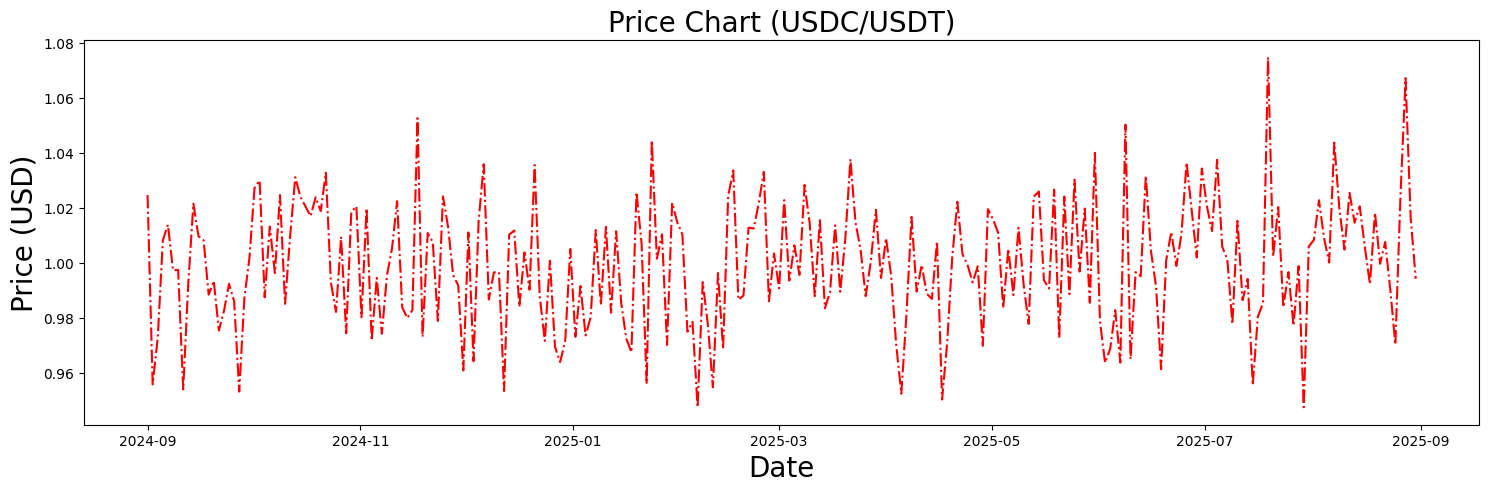

In [5]:
# *************************
# *** Simulation
# *************************
n_sim_runs = 250
seconds_year = 31536000
shape = 2000
scale = 0.0005

p_arr = np.random.gamma(shape = shape, scale = scale, size = n_sim_runs)

n_runs = len(p_arr)-1    
dt = datetime.timedelta(seconds=seconds_year/(n_sim_runs))
dates = [datetime.datetime.strptime("2024-09-01", '%Y-%m-%d') + k*dt for k in range(n_sim_runs)]   

x_val = np.arange(0,len(p_arr))
fig, (USD_ax) = plt.subplots(nrows=1, sharex=False, sharey=False, figsize=(18, 5))
USD_ax.plot(dates, p_arr, color = 'r',linestyle = 'dashdot', label='initial invest') 
USD_ax.set_title(f'Price Chart ({tkn_nm}/{usdt_nm})', fontsize=20)
USD_ax.set_ylabel('Price (USD)', size=20)
USD_ax.set_xlabel('Date', size=20)

## Pool configuration

In [6]:
tkn0_amt_usd = 1000000
invest_amt_usd = 100
exe_contract = True
skip_sim = True
contract_time_lapse = 0.5

tkn0_amt = UniV3Helper().dec2gwei(tkn0_amt_usd)
tkn1_amt = int(p_arr[0]*tkn0_amt)
deploy_amt =  UniV3Helper().dec2gwei(tkn0_amt_usd/5)
mint_amt =  UniV3Helper().dec2gwei(tkn0_amt_usd/10)
invest_amt =  UniV3Helper().dec2gwei(invest_amt_usd)

67472.55167853675

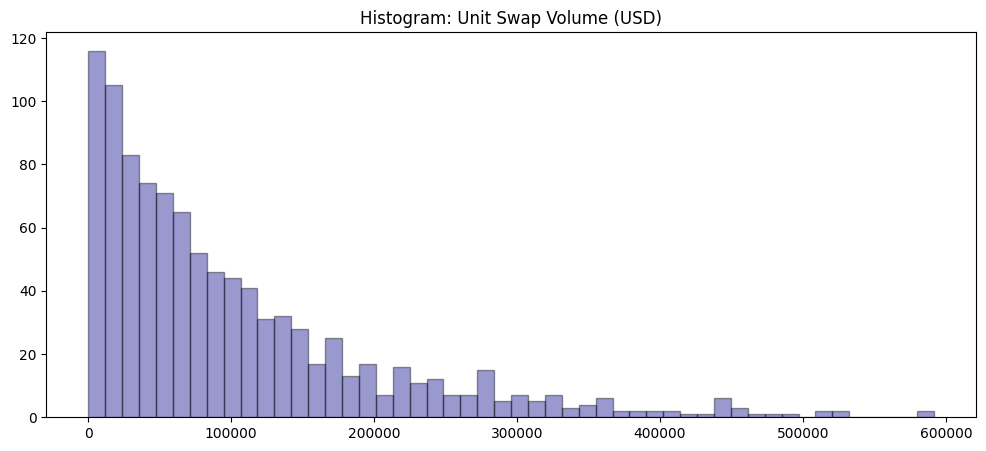

In [7]:
mrk_cap = UniV3Helper().gwei2dec(tkn0_amt)
TKN_amt = TokenDeltaModel(500000) # validated model
swap_arr = np.array([TKN_amt.delta() for k in range(1000)])

fig, ax = plt.subplots(1, 1, figsize=(12,5))

sns.distplot(swap_arr, hist=True, kde=False, bins=int(50), color = 'darkblue',
             hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 2}, ax=ax)
ax.set_title('Histogram: Unit Swap Volume (USD)')
np.median(swap_arr)

## Deploy pool - Contracts

In [8]:
deploy_args = [tkn0_amt, tkn1_amt, deploy_amt, mint_amt]
exe.apply(deploy_tree_path, rpc_url, verbose=True, args=deploy_args, skip_sim=False)

No files changed, compilation skipped
EIP-3855 is not supported in one or more of the RPCs used.
Unsupported Chain IDs: 31337.
Contracts deployed with a Solidity version equal or higher than 0.8.20 might not work properly.
For more information, please see https://eips.ethereum.org/EIPS/eip-3855
Script ran successfully.

== Logs ==
  tkn0Amt = 1000000000000000000000000
  tkn1Amt = 1024785266376094584406016
  deployAmt = 200000000000000000000000
  token0Bal = 200000000000000000000000
  UniV2 totalSupply = 1012316781633147966656664
  UniV2 Actual totalSupply = 1012316781633147966656664
  UniV2 baseReserve0 = 1000000000000000000000000
  UniV2 baseReserve1 = 1024785266376094584406016

## Setting up 1 EVM.


Chain 31337

Estimated gas price: 0.000000017 gwei

Estimated total gas used for script: 22663731

Estimated amount required: 0.000000000385283427 ETH




ONCHAIN EXECUTION COMPLETE & SUCCESSFUL.

Transactions saved to: /Users/ian_moore/repos/onchain-sim/broadcast/SimTestNetDeployPool.s.

## Retrieve configurations - Contracts

In [9]:
test_net_addresses_path = '/Users/ian_moore/repos/onchain-sim/script/deployments/SimTestNet-addresses.json'

f = open(test_net_addresses_path)
test_net_addresses = json.load(f)
univ2_pool_addr = test_net_addresses['uniV2Pool']
tkn0_addr = test_net_addresses['tkn0']
tkn1_addr = test_net_addresses['tkn1']
uniV2Factory_addr = test_net_addresses['uniV2Factory']

abi = ABILoad(Platform.SUSHI, JSONContract.UniswapV2Pair)
contract_interface = abi.get_abi_by_filename(abi.get_abi_path())
connect = ConnectW3(Net.LOCALHOST)
connect.apply()
w3 = connect.get_w3()

univ2_pool_contract = w3.eth.contract(address=w3.to_checksum_address(univ2_pool_addr), abi=contract_interface['abi'])

In [10]:
univ2_pool_contract = w3.eth.contract(address=w3.to_checksum_address(univ2_pool_addr), abi=contract_interface['abi'])
univ2_reserves = univ2_pool_contract.functions.getReserves().call() 
lp_amt = univ2_pool_contract.functions.totalSupply().call() 

## Deploy pool - Python

In [11]:
user_nm = 'user_machine_check'
token0Addr = '0x01'
token1Addr = '0x02'
basePoolAddr = '0x05'

tkn_nm = 'USDC'
usdt_nm = 'USDT'

In [12]:
(univ2_res0, univ2_res1, lp_amt) = UniswapScriptHelper().pool_state(univ2_pool_contract)

tkn1 = ERC20(tkn_nm, "0x09")
usdt1 = ERC20(usdt_nm, "0x111")
exchg_data = UniswapExchangeData(tkn0 = tkn1, tkn1 = usdt1, symbol="LP", address="0x011")

iVault1 = IndexVault('iVault1', "0x7")
factory = UniswapFactory(f"{tkn_nm} pool factory", "0x2")
lp = factory.deploy(exchg_data)
Join().apply(lp, user_nm, UniV3Helper().gwei2dec(univ2_res0), UniV3Helper().gwei2dec(univ2_res1))

lp.summary()

Exchange USDC-USDT (LP)
Reserves: USDC = 1000000.0, USDT = 1024785.2663760945
Liquidity: 1012316.781633148 



## Rebalance pool - Python

In [13]:
# Re-balance LP price
if(lp.get_reserve(usdt1) > lp.get_reserve(tkn1)):
    SwapDeposit().apply(lp, tkn1, user_nm, lp.get_reserve(usdt1) - lp.get_reserve(tkn1))
else:
    SwapDeposit().apply(lp, usdt1, user_nm, lp.get_reserve(tkn1) - lp.get_reserve(usdt1))

sDel_base = SolveDeltas(lp)

lp.summary()

Exchange USDC-USDT (LP)
Reserves: USDC = 1024785.2663760945, USDT = 1024785.2663760945
Liquidity: 1024766.5357236671 



## Rebalance pool - Contracts

In [14]:
exe.apply(rebalance_path, rpc_url, verbose=True, skip_sim=False)

No files changed, compilation skipped
EIP-3855 is not supported in one or more of the RPCs used.
Unsupported Chain IDs: 31337.
Contracts deployed with a Solidity version equal or higher than 0.8.20 might not work properly.
For more information, please see https://eips.ethereum.org/EIPS/eip-3855
Script ran successfully.

== Logs ==
  uniV2PoolAddr = 0x202066ED16184DEC6297D0b897956067159203a4
  iUniV2PoolAddr = 0x426096E5311d0e2024c9df1208BeA0b2CbD2c342
  tkn0Addr = 0x9DB6fbB164c6195EF2FB1f533eFcc52853FeA68A
  tkn1Addr = 0x1adFDB0E066F27431EC6a5fCCd26CFc32328e97d
  proceedsAmount = 12449981646756178455647
  UniV2 totalSupply = 1024766535723667141357074
  UniV2 baseReserve0 = 1024785266376094584406016
  UniV2 baseReserve1 = 1024785266376094584406016

## Setting up 1 EVM.


Chain 31337

Estimated gas price: 0.000000017 gwei

Estimated total gas used for script: 414938

Estimated amount required: 0.000000000007053946 ETH




ONCHAIN EXECUTION COMPLETE & SUCCESSFUL.

Transactions saved to: /

## Investment position - Contracts

In [15]:
invest_args = [invest_amt]
exe.apply(invest_path, rpc_url, args=invest_args, verbose=True, skip_sim=False)

output_dir = '/onchain-sim/script/deployments/'
output_file = 'SimTestNet-investment.json'
output_file_path = os.getcwd()+output_dir+output_file
with open(output_file_path) as f:
    contract_output = json.loads(f.read())

lp1_invest_track_contract = UniV3Helper().gwei2dec(contract_output['yieldOut'])

No files changed, compilation skipped
EIP-3855 is not supported in one or more of the RPCs used.
Unsupported Chain IDs: 31337.
Contracts deployed with a Solidity version equal or higher than 0.8.20 might not work properly.
For more information, please see https://eips.ethereum.org/EIPS/eip-3855
Script ran successfully.

== Logs ==
  uniV2PoolAddr = 0x202066ED16184DEC6297D0b897956067159203a4
  iUniV2PoolAddr = 0x426096E5311d0e2024c9df1208BeA0b2CbD2c342
  tkn0Addr = 0x9DB6fbB164c6195EF2FB1f533eFcc52853FeA68A
  tkn1Addr = 0x1adFDB0E066F27431EC6a5fCCd26CFc32328e97d
  devs = 0xf39Fd6e51aad88F6F4ce6aB8827279cffFb92266
  proceedsAmount = 49921237483603525963
  UniV2 totalSupply = 1024816458480638299623822
  UniV2 totalSupply = 1024816458480638299623822
  UniV2 baseReserve0 = 1024785266376094584406016
  UniV2 baseReserve1 = 1024885266376094584406016
  yieldOut = 49922756971158266748
  yieldOut = 49922756971158266748

## Setting up 1 EVM.


Chain 31337

Estimated gas price: 0.000000017 gwei

Es

## Investment position - Python

In [16]:
invested_user_nm = 'invested_user'
tkn_invest_amt = UniV3Helper().gwei2dec(invest_amt)

SwapDeposit().apply(lp, tkn1, invested_user_nm, tkn_invest_amt)
lp.summary()

lp_invest_track  = lp.get_liquidity_from_provider(invested_user_nm)
tkn_redeem_parent = LPQuote(False).get_amount_from_lp(lp, tkn1, lp_invest_track)
print(f'{tkn_redeem_parent:.3f} USDC redeemed from {lp_invest_track:.3f} LP tokens if {UniV3Helper().gwei2dec(invest_amt):.1f} invested USDC immediately pulled from parent')

Exchange USDC-USDT (LP)
Reserves: USDC = 1024885.2663760945, USDT = 1024785.2663760945
Liquidity: 1024816.4584806382 

99.700 USDC redeemed from 49.923 LP tokens if 100.0 invested USDC immediately pulled from parent


## Check pool - Contracts

In [17]:
exe.apply(check_amounts_path, rpc_url, verbose=True, skip_sim=False)

No files changed, compilation skipped
Script ran successfully.

== Logs ==
  uniV2PoolAddr = 0x202066ED16184DEC6297D0b897956067159203a4
  iUniV2PoolAddr = 0x426096E5311d0e2024c9df1208BeA0b2CbD2c342
  tkn0Addr = 0x9DB6fbB164c6195EF2FB1f533eFcc52853FeA68A
  tkn1Addr = 0x1adFDB0E066F27431EC6a5fCCd26CFc32328e97d
  UniV2 totalSupply = 1024816458480638299623822
  UniV2 totalSupply = 1024816458480638299623822
  UniV2 baseReserve0 = 1024785266376094584406016
  UniV2 baseReserve1 = 1024885266376094584406016


## Begin simulation

In [18]:
p_sim_arr1 = []; p_python_arr1 = []; p_contract_arr1 = []
p_sim_arr2 = []; p_python_arr2 = []; p_contract_arr2 = []
lp_direct_invest_arr = []; lp1_direct_invest_arr = []; lp1_tree_invest_arr = []; 

print('Begin onchain simulation\n')

for k in range(n_sim_runs):
    
    amt_swap = TKN_amt.delta()

    # ****************************************
    # ***** Calculate Arbitrage Amounts ******
    # ****************************************   
    p_sim1 = p_arr[k]
    (dep_tkn_x1, dep_tkn_y1, wd_tkn_x1, wd_tkn_y1, direction1) = helper.calc_arb_contract(lp, sDel_base, tkn1, usdt1, user_nm, p_sim1)
 
    # *****************************
    # **** Contract Arbitrage *****
    # *****************************  
    arb_args1 = [dep_tkn_x1, dep_tkn_y1, wd_tkn_x1, wd_tkn_y1, direction1]
    exe.apply(parent_arbitrage_path, rpc_url, args=arb_args1, verbose=False, skip_sim=skip_sim)
    (univ2_res0, univ2_res1, lp_amt) = helper.pool_state(univ2_pool_contract, verbose=False)
    price_tkn0_contract1 = univ2_res1/univ2_res0
    sleep(contract_time_lapse)

    # **************************************
    # ** Recalibrate Pool State - Python ***
    # **************************************   
    (univ2_res0, univ2_res1, lp_amt) = helper.pool_state(univ2_pool_contract)
    lp.reserve0 = univ2_res0; lp.reserve1 = univ2_res1; lp.total_supply = lp_amt
    price_tkn0_python1 = lp.get_price(tkn1)     

    # ************************************
    # ** Induce Trade Volume - Contract **
    # ************************************ 
    arb_args = [UniV3Helper().dec2gwei(amt_swap), 0]
    exe.apply(swap_path, rpc_url, args=arb_args, verbose=False, skip_sim=skip_sim)
    sleep(contract_time_lapse)
    
    # **************************************
    # ** Recalibrate Pool State - Python ***
    # **************************************  

    (univ2_res0, univ2_res1, lp_amt) = helper.pool_state(univ2_pool_contract)
    lp.reserve0 = univ2_res0; lp.reserve1 = univ2_res1; lp.total_supply = lp_amt

    # # ***********************************
    # # *** Induce Trade Volume - Python **
    # # *********************************** 
    
    # *****************************
    # ***** Data Collection *******
    # *****************************   
    p_sim_arr1.append(p_sim1)
    p_python_arr1.append(price_tkn0_python1)
    p_contract_arr1.append(price_tkn0_contract1)

    # investment performance
    tkn_redeem_parent = LPQuote(False).get_amount_from_lp(lp, tkn1, lp_invest_track)
    lp_direct_invest_arr.append(tkn_redeem_parent)

    if(k % int(n_sim_runs/int(n_sim_runs/10)) == 0):
        print(f'[UniV2: step {k}] Actual price {p_sim1:.5f} / Python price {price_tkn0_python1:.5f} / Contract price {price_tkn0_contract1:.5f}')
    
lp.summary()
tkn_redeem_parent = LPQuote(False).get_amount_from_lp(lp, tkn1, lp_invest_track)
print(f'{tkn_redeem_parent:.3f} USDC redeemed from {lp_invest_track:.3f} LP tokens if {UniV3Helper().gwei2dec(invest_amt):.1f} invested USDC pulled from parent (lp)')


Begin onchain simulation

[UniV2: step 0] Actual price 1.02479 / Python price 1.02480 / Contract price 1.02480
[UniV2: step 10] Actual price 1.00978 / Python price 1.00974 / Contract price 1.00974
[UniV2: step 20] Actual price 1.00188 / Python price 1.00139 / Contract price 1.00139
[UniV2: step 30] Actual price 1.02419 / Python price 1.02420 / Contract price 1.02420
[UniV2: step 40] Actual price 1.01859 / Python price 1.01793 / Contract price 1.01793
[UniV2: step 50] Actual price 0.98390 / Python price 0.98401 / Contract price 0.98401
[UniV2: step 60] Actual price 0.99558 / Python price 0.99558 / Contract price 0.99558
[UniV2: step 70] Actual price 0.95345 / Python price 0.95359 / Contract price 0.95359
[UniV2: step 80] Actual price 0.96954 / Python price 0.96961 / Contract price 0.96961
[UniV2: step 90] Actual price 1.01322 / Python price 1.01272 / Contract price 1.01272
[UniV2: step 100] Actual price 1.00163 / Python price 1.00160 / Contract price 1.00160
[UniV2: step 110] Actual pri

## Plot results

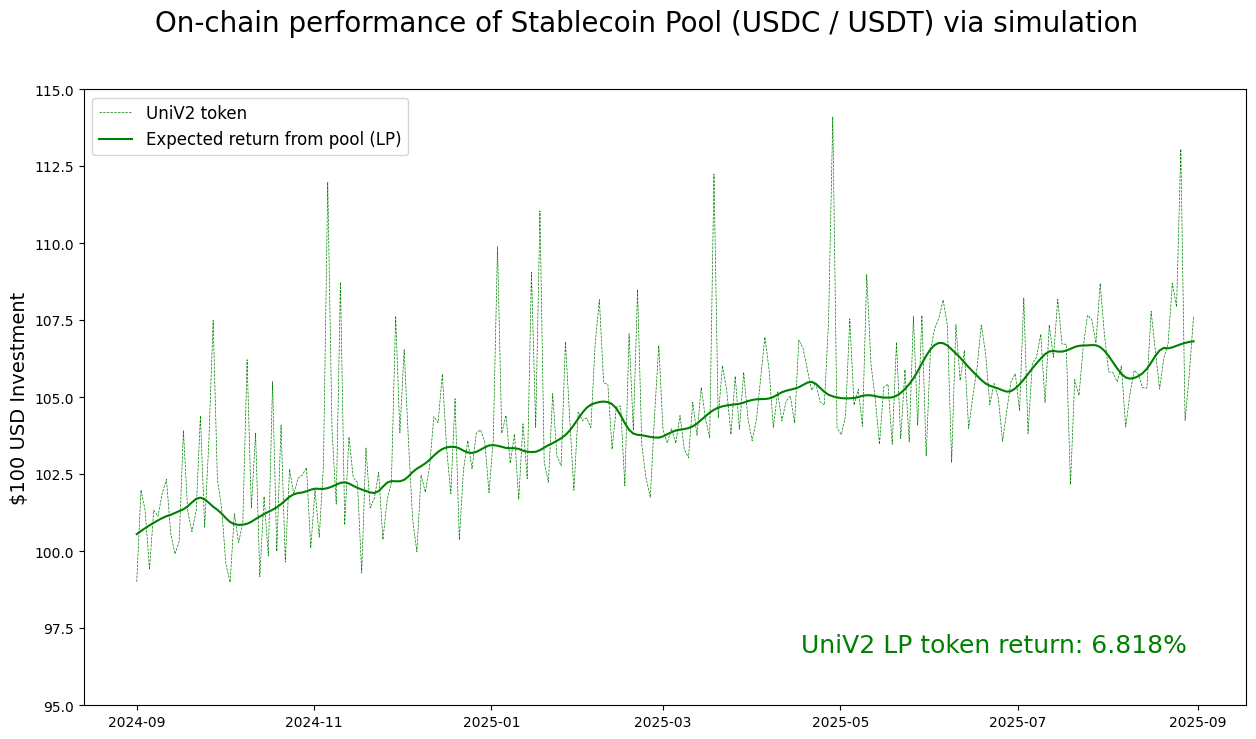

In [23]:
lp_direct_invest_arr = np.array(lp_direct_invest_arr)

lowess = sm.nonparametric.lowess
x = range(0,n_sim_runs)
res = lowess(lp_direct_invest_arr, x, frac=1/15); sm_lp_direct = res[:,1]
parent_return = 100*sm_lp_direct[-1]/invest_amt_usd-100

strt_ind = 0
fig, (p_ax) = plt.subplots(nrows=1, sharex=True, sharey=False, figsize=(15, 8))
fig.suptitle('On-chain performance of Stablecoin Pool (USDC / USDT) via simulation', fontsize=20)
p_ax.plot(dates[strt_ind:n_sim_runs], lp_direct_invest_arr[strt_ind:], linestyle='dashed', linewidth=0.5, color = 'g', label = 'UniV2 token') 
p_ax.plot(dates[strt_ind:n_sim_runs], sm_lp_direct[strt_ind:], color = 'g', label = 'Expected return from pool (LP)') 
p_ax.text(0.7, 0.1, f'UniV2 LP token return: {parent_return:.4}%', fontsize=18, color='g', horizontalalignment='left',verticalalignment='center',transform=ax.transAxes)
p_ax.set_ylim(UniV3Helper().gwei2dec(invest_amt)*95/100, UniV3Helper().gwei2dec(invest_amt)*115/100) 
p_ax.set_ylabel("$100 USD Investment", fontsize=14)
p_ax.legend(fontsize=12, loc='upper left')

## Check pool - Contracts

In [20]:
helper.pool_state(univ2_pool_contract, verbose=True)

TKN0 1274802.83 / TKN1 1245231.30 / Liquidity 1180726.03


(1274802827162854291002280,
 1245231301039386439386539,
 1180726028607479335107687)

In [21]:
exe.apply(check_amounts_path, rpc_url, verbose=True, skip_sim=False)

No files changed, compilation skipped
Script ran successfully.

== Logs ==
  uniV2PoolAddr = 0x202066ED16184DEC6297D0b897956067159203a4
  iUniV2PoolAddr = 0x426096E5311d0e2024c9df1208BeA0b2CbD2c342
  tkn0Addr = 0x9DB6fbB164c6195EF2FB1f533eFcc52853FeA68A
  tkn1Addr = 0x1adFDB0E066F27431EC6a5fCCd26CFc32328e97d
  UniV2 totalSupply = 1180726028607479335107687
  UniV2 totalSupply = 1180726028607479335107687
  UniV2 baseReserve0 = 1274802827162854291002280
  UniV2 baseReserve1 = 1245231301039386439386539


## Check pool - Python

In [22]:
lp.summary()

Exchange USDC-USDT (LP)
Reserves: USDC = 1274802.8271628544, USDT = 1245231.3010393865
Liquidity: 1180726.0286074793 

